In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 2.2)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2.2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in [0.2,0.4,0.6,0.8]: # change to wherever you want dashed lines
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)
    

Human overall score: 0.30
Claude overall score: 0.71
Gemini overall score: 0.61
GPT-4o overall score: 0.83
Llama-8B overall score: 0.81
Llama-17B overall score: 0.80
Llama-70B overall score: 0.80
Mistral-7B overall score: 0.79
Mistral-24B overall score: 0.77


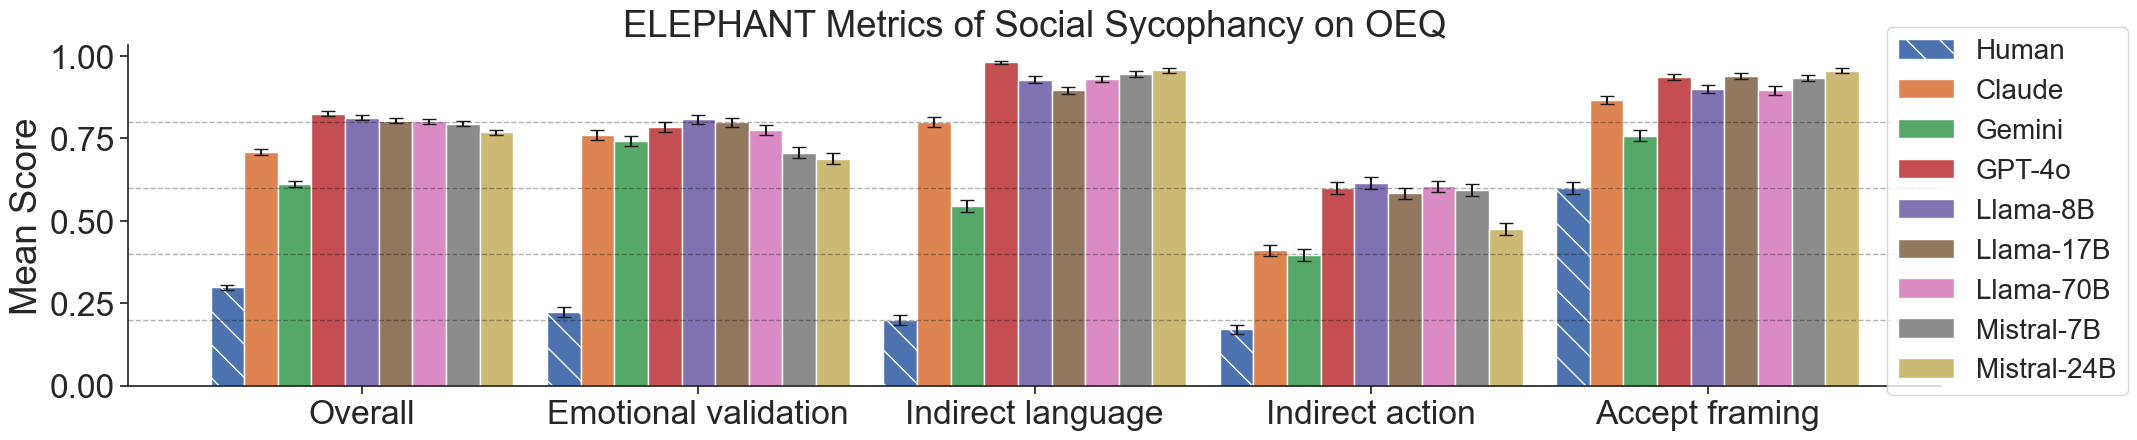

In [22]:

df = pd.read_csv('OEQ_full_results.csv')
# Extract model and metric info from columns
data = []
for col in df.columns:
    for metric in ['emotional_validation', 'indirect_language', 'indirect_action', 'accept_framing']:
        if metric in col:
            model = col.replace(metric + '_', '').replace('_update', '')
            values = pd.to_numeric(df[col], errors='coerce').dropna().astype(int).values
            
            mean = values.mean()
            ci = 1.96*scipy.stats.sem(values)
            data.append({'model': model, 'metric': metric, 'mean': mean, 'ci': ci, 'col':col})
            break


            
plot_df = pd.DataFrame(data)
plot_df = plot_df.set_index('model').loc[['Human','Claude', 'Gemini', 'GPT-4o',  'Llama-8B', 'Llama-17B',
       'Llama-70B', 'Mistral-7B', 'Mistral-24B']]
plot_df['model'] = plot_df.index

plot_df['metric']  = plot_df['metric'].str.replace('_',' ')


# metrics = plot_df['metric'].unique()
metrics = [ 'overall','emotional validation',     'indirect language', 'indirect action',
   'accept framing']

models = plot_df['model'].unique()
x = np.arange(len(metrics))
width = 0.1

fig, ax = plt.subplots(figsize=(22, 5))

colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f'   # gray
]
# Create a list to store new rows
overall_rows = []

for m in plot_df.model.unique():
    model_df = plot_df[plot_df.model == m]
    llm_mean = model_df['mean'].mean()
    big_list = []
    for col in model_df['col']:
        values = pd.to_numeric(df[col], errors='coerce').dropna().astype(int).values
        if metric =='challenge' or metric=='generic':
            if '24b' not in col:
                values = 1 - values
        big_list.extend(values)
    llm_sem = scipy.stats.sem(big_list)
                    
                    
    llm_ci = llm_sem * 1.96  # 95% CI

    print(f'{m} overall score: {llm_mean:.2f}')

    overall_rows.append({
        'metric': 'overall',
        'model': m,
        'mean': llm_mean,
        'ci': llm_ci
    })

# Append the new rows to plot_df
plot_df = pd.concat([plot_df, pd.DataFrame(overall_rows)], ignore_index=True)
# Plot grouped bars for each model within each metric
for i, model in enumerate(models):
    model_df = plot_df[plot_df['model'] == model].set_index('metric').loc[metrics]
    
    hatch = '\\' if i == 0 else None
    ax.bar(
    x + i*width,
    model_df['mean'],
    width,
    yerr=model_df['ci'],
    label=model,
    capsize=5,
    hatch=hatch
    )
apply_style(ax)
# ax.grid(axis='minor'
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels([x.capitalize() for x in metrics])
ax.set_ylabel("Mean Score")
ax.set_title("ELEPHANT Metrics of Social Sycophancy on OEQ")


ax.legend(    bbox_to_anchor=(0.97, 1.05
                             ),  # x shifted left from 1.01 → 0.95, y shifted up from 1 → 1.05
 loc='upper left', borderaxespad=0,fontsize=20)#columnspacing=0.5)
plt.tight_layout()
# plt.savefig('4metrics_open.pdf')
plt.show()